# Homework 2
**Author: Morgan Byers**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def update(t, delta_t, current_val, f_prime):
    return current_val + (delta_t * f_prime(current_val))

In [3]:
#define derivatives
def s_dot(beta, I):
    return lambda S : (-1 * beta * S * I) + (gamma * I)

def i_dot(beta, gamma, S):
    return lambda I : (beta * S * I) - (gamma * I)

In [4]:
#solver
def solve(init_conditions, delta_t, max_time, beta, gamma):
    #set up experiment loop
    t = [init_conditions[0]]
    S =[init_conditions[1]]
    I = [init_conditions[2]]
    
    idx=0
    
    while t[idx] < max_time:
        #create derivatives
        s_update = s_dot(beta, I[idx])
        i_update = i_dot(beta, gamma, S[idx])
        
        #update S, I, R
        S.append(update(t[idx], delta_t, S[idx], s_update))
        I.append(update(t[idx], delta_t, I[idx], i_update))
    
        #upate time
        t.append(t[idx] + delta_t)
        idx += 1

    return t, S, I

## Problem 1

### Part a

In [25]:
def plot(t, I, gamma, beta, delta_t, save=True):
    plt.plot(t, I, color='red', label = r'$i$')
    plt.hlines(1 - gamma / beta, t[0], t[-1], color='black', linestyle='dashed', label = r'$i_{eq}$')
    
    plt.ylim([0, 0.5])
    plt.xlim([t[0], t[-1]])
    
    plt.ylabel('Normalized Infections')
    plt.xlabel('Time')
    
    plt.title(rf'Infections over time, $\Delta t = {delta_t}$')
    plt.legend(loc='lower right')

    if save:
        plt.savefig(f'infections_delta={delta_t}.png', dpi=200, bbox_inches='tight')
    plt.show()

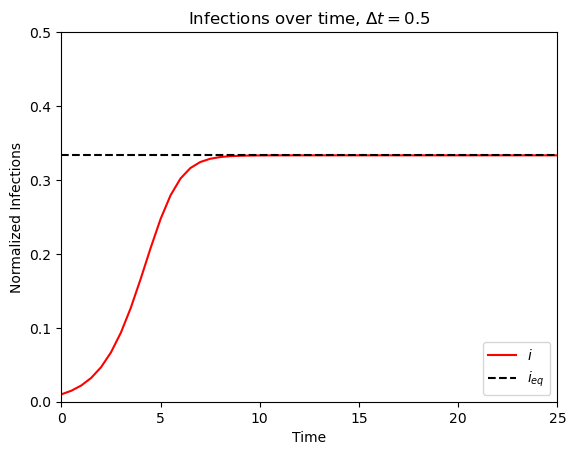

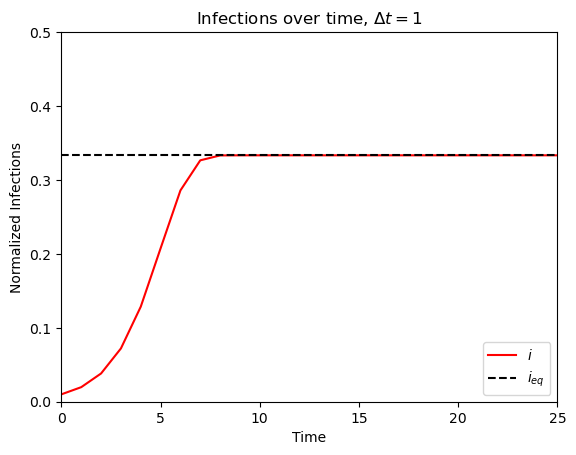

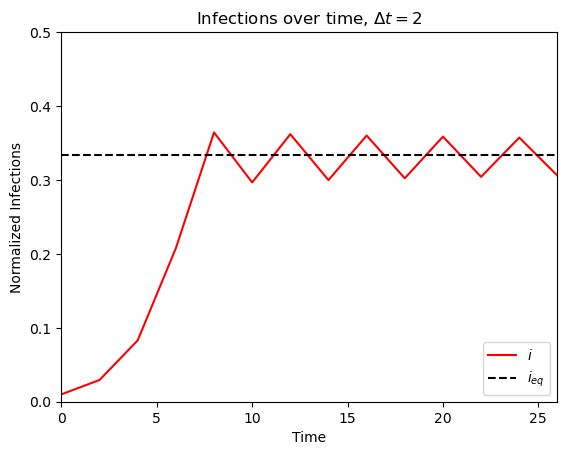

In [27]:
#set up initial conditions
s_init = 0.99
i_init = 0.01
t_init = 0

beta = 3
gamma = 2

delta_ts = [0.5, 1, 2]
max_t = 25

init_conditions = [t_init, s_init, i_init]

for delta_t in delta_ts:
    t, S, I = solve(init_conditions, delta_t, max_t, beta, gamma)
    plot(t, I, gamma, beta, delta_t)

### Part c

In [5]:
def error(i_euler, i_analytical):
    difference = np.subtract(i_euler, i_analytical)
    return np.max(np.abs(difference))

In [6]:
def i_analytical(i_init, beta, gamma):
    #we have a closed form solution for i
    R = beta / gamma
    numerator = 1 - (1 / (R))
    factor = (1 - (1 / R) - i_init) / i_init
    return lambda t: numerator / (1 + factor * np.exp(-(beta-gamma)*t))

def solve_analytical(init_conditions, delta_t, max_t, beta, gamma):
    t = [init_conditions[0]]
    #we don't care about s_0 here
    i = [init_conditions[2]]

    idx = 0

    #set up i's analytical solution
    i_solution = i_analytical(i[0], beta, gamma)

    while t[idx] < max_t:
        t.append(t[idx] + delta_t)
        i.append(i_solution(t[idx+1]))
        idx += 1

    return t, i

In [37]:
def plot(delta_ts, errors, save=True):
    plt.scatter(delta_ts, errors, color='black', s=4)
    
    plt.yscale('log')
    plt.xscale('log')
    
    plt.xlabel(r'$\Delta t$')
    plt.ylabel(r'$E(\Delta t)$')

    plt.xticks(delta_ts, labels=delta_ts)
    plt.yticks(errors, labels=[f'{e:.3f}' for e in errors])
    plt.minorticks_off()

    plt.title(r'$E(\Delta t)$ vs. $t$')

    if save:
        plt.savefig('errors_v_time.png', dpi=200, bbox_inches='tight')
    plt.show()

In [17]:
#set up initial conditions
s_init = 0.99
i_init = 0.01
t_init = 0

beta = 3
gamma = 2

delta_ts = [2, 1, 1/2, 1/4, 1/8, 1/16, 1/32]
max_t = 25

init_conditions = [t_init, s_init, i_init]
errors = []

#solve loop
for delta_t in delta_ts:
    t, _, i_euler = solve(init_conditions, delta_t, max_t, beta, gamma)
    t, i_analytical_sol = solve_analytical(init_conditions, delta_t, max_t, beta, gamma)

    errors.append(error(i_analytical_sol, i_euler))

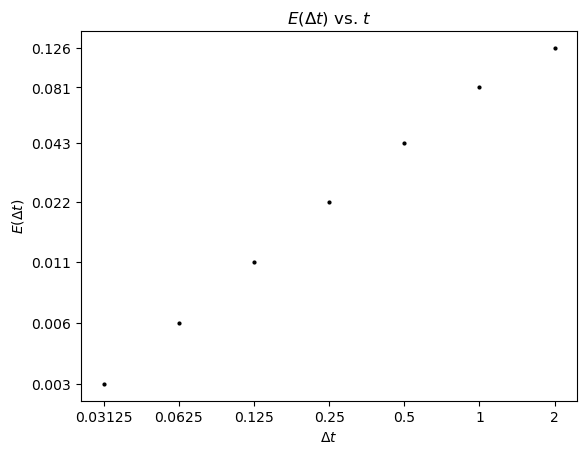

In [39]:
plot(delta_ts, errors, save=True)